# Tensorflow 分布式模型训练原理

distributed tensorflow可以利用分布式来更好的并行利用大量的计算资源来实现数据并行，提高数据吞吐率以及training的速度。如下图所示，用分布式tensorflow来并行计算和训练模型，从25个GPU扩展到200个GPU，数据的吞吐量也从500 Images/s显著提高到2000 Images/s以上。

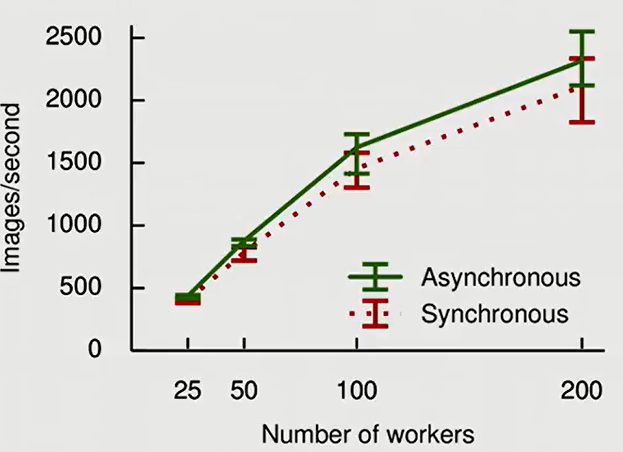

TensorFlow的并行计算形式分为单台服务器内多块GPU（简称“单机多卡”）并行和若干台多卡服务器（简称“多机多卡”）并行。

分布式TensorFlow涉及以下几个方面的内容：

* Replicating your model (复制模型)

* Device placement for Variables (如何为参数放置设备资源)

* 定义分布式Tensorflow集群

* Fault tolerance (容错设计)

## Replication

### In-graph replication

Tensorflow只使用1个CPU核心，即cpu0。绝大多数计算量均由GPU完成。

为了使所有GPU同时工作，需要将计算图划分为多个子图，每个子图对应一个GPU。CPU将各个子图上的计算任务指派给其对应的GPU，全程集中调度，调度过程大致如下：

* 计算图初始化：组装出计算图，给变量赋初值、生成随机数等。

* 划分子图：原则是子图之间的相互依赖尽量弱，各子图上包含的计算量尽量均衡。

* 作业指派：CPU将子图中的操作指派给对应GPU进行运算，少量不能在GPU上完成的图节点由CPU完成；指派步骤包括先将所需数据复制到GPU上，再启动CUDA kernel来在这些数据上计算。

* 数据汇总交换：GPU使用自己显存上的数据更新图节点的值；CPU将所有子图的最新值从显存复制回CPU内存，汇总得到整个计算图的新值。然后将新值分发给各个GPU。

* 各个GPU使用新值进行下一轮计算。

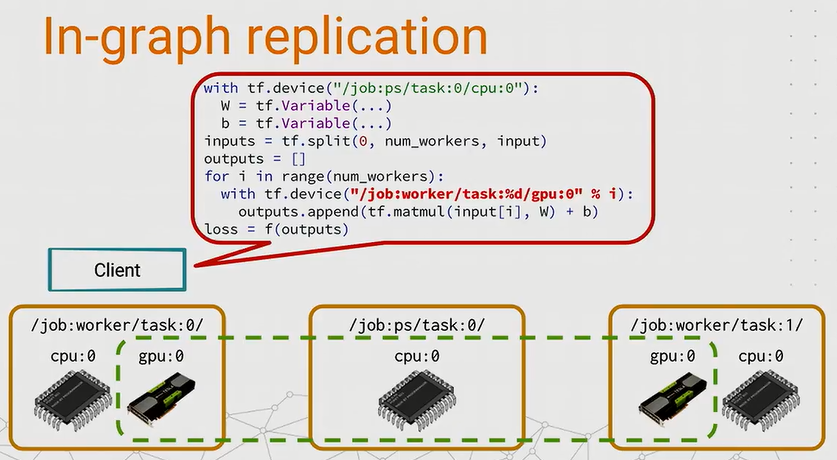

In-graph replication(图内复制)适合于单机多卡。对于多机多卡情况，如果采用图内复制，分发数据带来的数据瓶颈就会比较大，数据传输会产生瓶颈。

### Between-graph Replication

In-graph Replication 只能使用一台服务器，GPU数量有限，导致大规模训任务练动辄消耗几天几周的时间，效率低下。

但是，如果将计算图剖分成多个子图，将一个子图指派给一台服务器，那么将面临几个难题：

* 计算图不够大，难以划分出足够多的子图。例如采用100台服务器，而深度神经网络只有1个输入层（784个神经元）、1个隐层（30个神经元）、1个输出层（10个神经元），这样的计算图几乎是不可剖分的。如果按神经元的层剖分，就是3级流水线，效率不高不说，关键是只能指派给3台服务器。

* 网络通信压力大：子图之间多多少少都有一些依赖关系，即使强行剖分成N个子图，子图之间的数据交换将带来巨大的网络压力，影响整体计算效率。

In-graph Replication 不存在这两个难题，原因有两个：

* 需要子图数量少（通常2/4个，多的8/16个），从而剖分容易；

* 在服务器内存中汇总交换数据，PCIe的带宽和延时性能都比服务器之间的网络性能好很多。

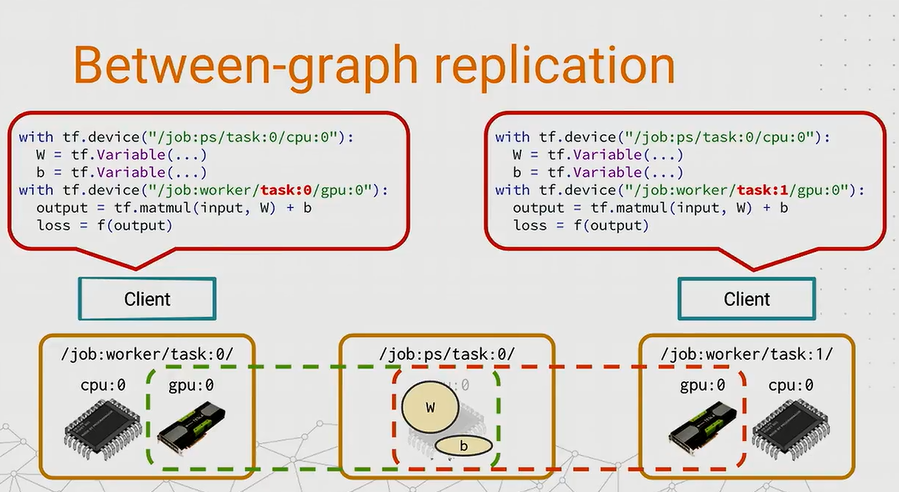

当在运行多个client时，由中间的PS task来交互client之间的数据变化。实现原理是，当有两个worker task时，会创建两个同样名字的变量，然后放在PS中的内存中共享，当一个worker task更新了变量，那个对于另一个task也是可见的，所以这样可以训练得更快。

TensorFlow 封装了高级 API，会自动把参数部署到参数服务器上，把运算操作设定到 worker 上，从而实现一份代码可在多个 worker 上运行，简化客户端程序的编写。

## Device placement for Variables (如何为参数放置设备资源)

用Tensorflow中不同的设备函数来创建更多更加巧妙强大的参数放置策略。

### Round-robin variables

最简单的一个方法叫做`tf_train_replica_device_setter`方法，它会循环的分配变量。如下图所示，指定3个ps_tasks时，这个程序会把weights_1权重变量被放在到PS task0，biases_1偏置变量被放置到PS task1, weights_2权重变量被放置到PS task2，biases_2放到task0中。

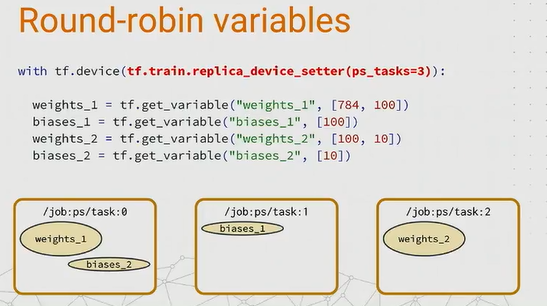

**优点**：可以把整个模型建模代码用这个模块包起来。它只影响变量，把它们放在PS任务中，而其他的工作会自动到worker中执行。

**缺点**：并不是一个最优的平衡负载放置策略。

### Load balancing variables

有一个简单的贪婪策略叫`GreedyLoadBalancingStrategy`,它可以根据参数的内存字节来完成类似在线垃圾收集的工作。根据weight和bias的字节数来放置到内存合适的task中，带来更好的负载平衡。

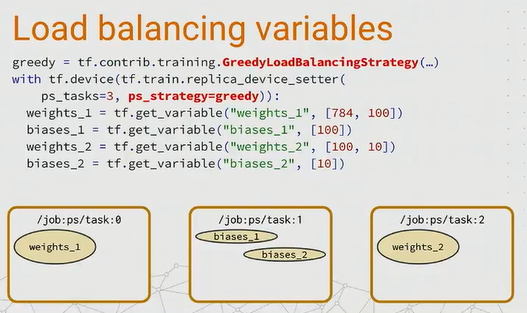

### Partitioned variables

以上讨论的都是很小字节的参数，每个PS task都可以单独处理一个变量。但当遇到超大字节，比如可能是几万MB的数据该如何处理？为解决这个问题，提出了一个分割变量的方法。假设你用分隔符创建了一个变量，tensorflow会把这个变量分割成3个部分，分发到3个PS task中。

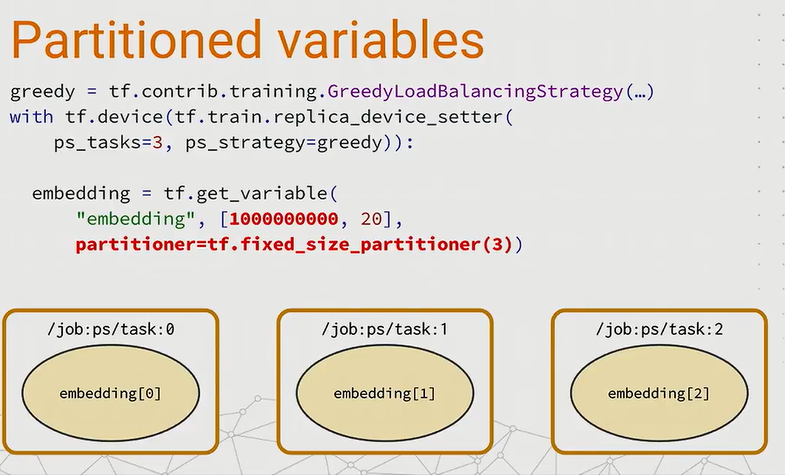

## 定义分布式Tensorflow集群

### Tensorflow集群基本概念

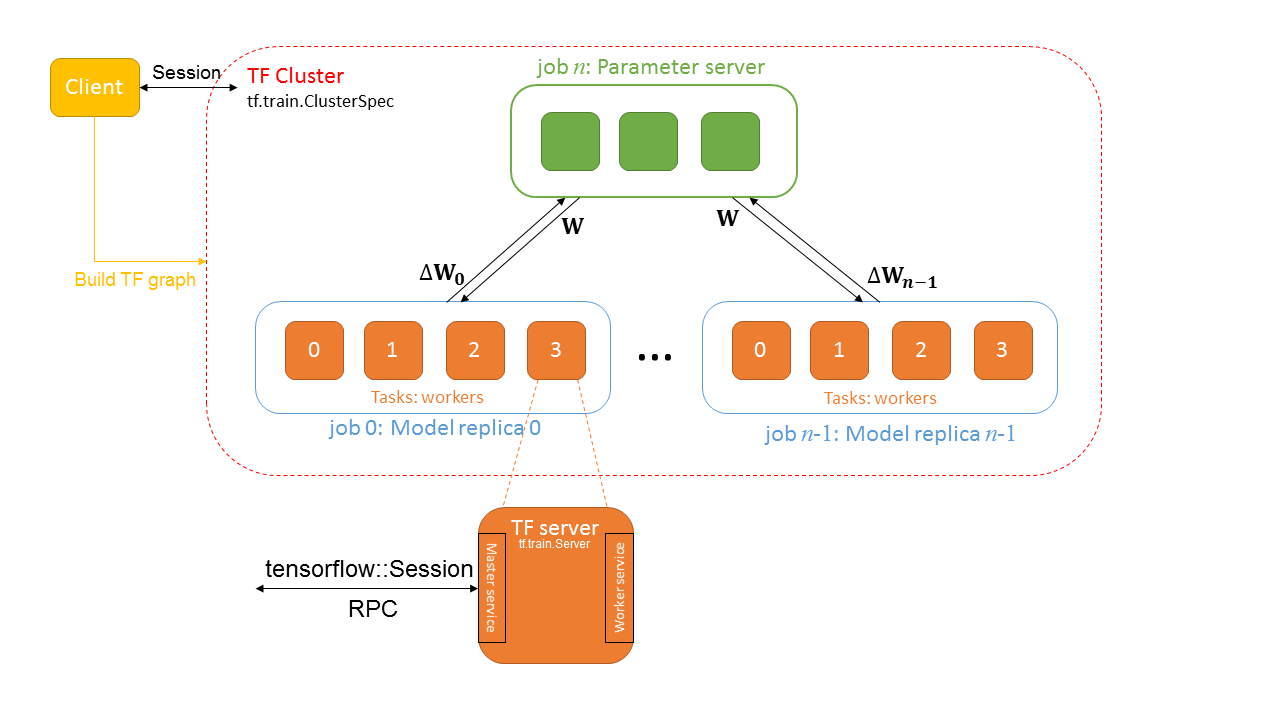

#### gRPC

分布式Tensorflow底层的通信是gRPC。  

gRPC是一个RPC,即远程过程调用。通俗的解释是：假设在本机上执行一段代码`num=add(a,b)`，它调用了一个过程call，然后返回一个值num。这段代码看上去只是在本机上执行的，但实际情况是，本机上的add方法是将参数打包发送给服务器，然后服务器运行服务器端的add方法，返回的结果再将数据打包返回给客户端。

#### Cluster

一个Tensorflow Cluster有一个或多个jobs组成，每个job又由一个或多个tasks构成。  

Cluster的定义通过`tf.train.ClusterSpec`来定义的。 

Tensorflow一般将任务分为两类Job:

* 一类叫参数服务器，parameter server,简称为ps,用于管理参数的存储和更新工作；

* 一类就是普通任务，称为worker，用于执行具体的计算。如果参数的数量太大，一台机器处理不了，这就需要多个Tasks。即Job是Task的集合。

#### Client

Client用来build一个Tensorflow Graph，并构建一个tensorflow::Session用来与集群通信。一个Client可以与多个Tensorflow Server交互，一个Server能服务多个Client。

#### Job

一个Job油tasks list组成，Job分ps和worker两种类型。ps即parameter server，用来存储和更新variables的，而worker可以认为是无状态的，用来作为计算任务的。workers中，一般都会选择一个chief worker（通常是worker0），用来做训练状态的checkpoint，如果有worker故障，那么可以从最新checkpoint中restore。

#### Task

每个Task对应一个TensorFlow Server，对应一个单独的进程。一个Task 属于某个Job，通过一个index来标记它在对应Job的tasks中的位置。每个TensorFlow均实现了 Master service 和 Worker service。Master service用来与集群内的worker services进行grpc交互。Worker service 则是用local device来计算subgraph。

### Tensorflow集群定义

In [ ]:
import tensorflow as tf 
# Configuration of cluster 
ps_hosts = [ "xx.xxx.xx.xxxx:oooo", "xx.xxx.xx.xxxx:oooo" ] 
worker_hosts = [ "xx.xxx.xx.xxxx:oooo", "xx.xxx.xx.xxxx:oooo", "xx.xxx.xx.xxxx:oooo" ] 
cluster = tf.train.ClusterSpec({"ps": ps_hosts, "worker": worker_hosts}) 

上面的语句提供了一个TensorFlow集群定义，集群有两类Job，一类是ps，另一类是worker；ps由2个任务组成，worker由3个任务组成。 

> 可以借助Kubernetes来进行TensorFlow集群定义。 

定义完集群信息后，使用`tf.train.Server`创建每个任务：

In [ ]:
tf.app.flags.DEFINE_string("job_name", "worker", "One of 'ps', 'worker'") 
tf.app.flags.DEFINE_integer("task_index", 0, "Index of task within the job") 
FLAGS = tf.app.flags.FLAGS 

def main(): 
    server = tf.train.Server(cluster, job_name=FLAGS.job_name, task_index=FLAGS.task_index) 
    server.join() 

if __name__ == "__main__": 
    tf.app.run() 

分布式任务启动，在 **ip:port** 对应的机器上运行每个任务（2个PS，3个Worker），共需执行五次代码，生成五个任务：

```
python worker.py --job_name=ps --task_index=0 
python worker.py --job_name=ps --task_index=1 
python worker.py --job_name=worker --task_index=0 
python worker.py --job_name=worker --task_index=1 
python worker.py --job_name=worker --task_index=2
```

完整例子： 

代码中，`tf.train.replica_device_setter()`会根据job名，将`with`内的`Variable` op放到ps tasks，将其他计算op放到worker tasks。默认分配策略是轮询。

In [ ]:
import tensorflow as tf 
import numpy as np 

# Configuration of cluster 
ps_hosts = [ "xx.xxx.xx.xxxx:oooo", "xx.xxx.xx.xxxx:oooo" ] 
worker_hosts = [ "xx.xxx.xx.xxxx:oooo", "xx.xxx.xx.xxxx:oooo", "xx.xxx.xx.xxxx:oooo" ] 
cluster = tf.train.ClusterSpec({"ps": ps_hosts, "worker": worker_hosts}) 
tf.app.flags.DEFINE_integer("task_index", 0, "Index of task within the job") 
FLAGS = tf.app.flags.FLAGS 

def main(): 
    with tf.device(tf.train.replica_device_setter(worker_device="/job:worker/task:%d" % FLAGS.task_index, cluster=cluster)): 
        x_data = tf.placeholder(tf.float32, [100]) 
        y_data = tf.placeholder(tf.float32, [100]) 
        W = tf.Variable(tf.random_uniform([1], -1.0, 1.0)) 
        b = tf.Variable(tf.zeros([1])) 
        y = W * x_data + b 
        loss = tf.reduce_mean(tf.square(y - y_data)) 
        global_step = tf.Variable(0, name="global_step", trainable=False) 
        optimizer = tf.train.GradientDescentOptimizer(0.1) 
        train_op = optimizer.minimize(loss, global_step=global_step) 
        tf.summary.scalar('cost', loss) 
        summary_op = tf.summary.merge_all() 
        init_op = tf.global_variables_initializer() # The StopAtStepHook handles stopping after running given steps. 
        hooks = [ tf.train.StopAtStepHook(last_step=1000000)] # The MonitoredTrainingSession takes care of session initialization, 
        # restoring from a checkpoint, saving to a checkpoint, and closing when done 
        # or an error occurs. 
        # 我们制定task_index为0的任务为主任务，用于负责变量初始化、做checkpoint、保存summary和复原 checkpoint_dir="/tmp/tf_train_logs",
        with tf.train.MonitoredTrainingSession(master="grpc://" + worker_hosts[FLAGS.task_index], is_chief=(FLAGS.task_index==0), 
                                                save_checkpoint_secs=None, hooks=hooks) as mon_sess: 
            while not mon_sess.should_stop(): 
            # Run a training step asynchronously. 
            # See `tf.train.SyncReplicasOptimizer` for additional details on how to 
            # perform *synchronous* training. 
            # mon_sess.run handles AbortedError in case of preempted PS. 
                train_x = np.random.rand(100).astype(np.float32) 
                train_y = train_x * 0.1 + 0.3 
                _, step, loss_v, weight, biase = mon_sess.run([train_op, global_step, loss, W, b], 
                feed_dict={x_data: train_x, y_data: train_y}) 
            if step % 100 == 0: 
                print("step: %d, weight: %f, biase: %f, loss: %f" %(step, weight, biase, loss_v))
                print("Optimization finished." )
        
if __name__ == "__main__": 
    tf.app.run()

### 容错恢复

#### 非 chief 的 worker task 失败

因为非 Chief worker task实际上是无状态的，恢复的时候，它会重新与它的PS task中建立连接，并且重新开始之前崩溃过的进程。

#### PS task 失败

因为PS task是有状态的，所有的worker task需要依赖PS task来发送它们的梯度并且取得新的参数值。`chief worker task`负责监测这种错误，如果发生了这种错误，`chief worker task`就打断整个训练，并从上一个检查点恢复所有的PS tasks。

#### chief worker task 失败

因为 chief worker task 负责其他所有的任务，需要确保它失败时能够让集群里所有的任务都回到一个很好的状态。如果发生了这种错误，打断训练，并在当它恢复了时候从上一个好的检查点恢复。

> 可以使用一个配置比如Hadoop ZooKeeper 或Etcd来选举`chief worker task`而不是简单地定义为task0。